# Effects of Flight Parameters on Arrival Delay
## by Luke DeMaster-Smith

## Investigation Overview

* In this investigation, I wanted to assess which features best predict or correlate to the length of arrival delays for U.S. domestic flights.

## Dataset Overview

* The [dataset I used](http://stat-computing.org/dataexpo/2009/the-data.html) for this investigation was quite large:
  * A single year (2008) has 7 million flights and each flight has 29 associated data fields of data.
  * There are 22 years worth of data.
  * Given the size of the dataset, I chose to focus my investigation on flight delays during the most recent year of data, 2008.
<br><br>

* I assessed many of the 29 parameters against Arrival Delay, ultimately arriving at the following variables of particular interest:
  * Weather Delay
  * Destination
  * Airline
  * Day / Week of Year

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random
random.seed(42)

import time           # for timing operations on large dataframes

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load a single year's dataset into a pandas dataframe
flights = pd.read_csv('2008.csv')           #flights_2008

In [3]:
# Backup the data
flights_orig = flights.copy(deep=True)   # version to leave unaltered
flights_all = flights.copy(deep=True)    # version to modify / use as necessary

In [10]:
# sample 100000 flights
samples = np.random.choice(flights_all.shape[0], 100000, replace = False)
flights = flights_all.loc[samples,:]

In [21]:
# add Date, Week, and DayOfYear parameters to the dataset
temp_date = pd.to_datetime(flights.Year*10000 +
                           flights.Month*100 +
                           flights.DayofMonth, format='%Y%m%d')
flights['Date'] = temp_date
flights['DayOfYear'] = flights['Date'].dt.dayofyear
flights['Week'] = flights['Date'].dt.week

# quick hack / correct issue where the last few days of the year errantly indicate 'Week' == 1
mask1 = flights.Month == 12
mask2 = flights.DayofMonth >= 29
flights.loc[mask1 & mask2, 'Week'] = 53

In [22]:
# also add Date, Week, DayOfYear parameters to the larger dataset (in case it is needed later)
temp_date = pd.to_datetime(flights_all.Year*10000 +
                           flights_all.Month*100 +
                           flights_all.DayofMonth, format='%Y%m%d')
flights_all['Date'] = temp_date
flights_all['DayOfYear'] = flights_all['Date'].dt.dayofyear
flights_all['Week'] = flights_all['Date'].dt.week

# quick hack / correct issue where the last few days of the year errantly indicate 'Week' == 1
mask1 = flights_all.Month == 12
mask2 = flights_all.DayofMonth >= 29
flights_all.loc[mask1 & mask2, 'Week'] = 53

## Distribution of Arrival Delays

* When plotting the distribution of Arrival Delays on a standard scale, one can see that many flights arrive early.
* However, when plotted on a logarithmic scale, one can see that sometimes Arrival Delays get quite large.

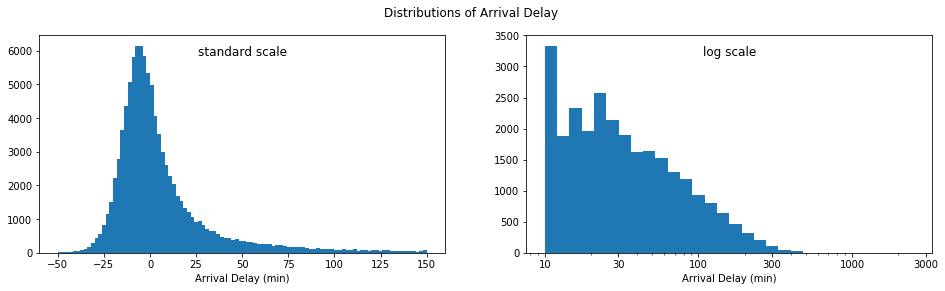

In [23]:
numPlots = 2
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = [8*numPlots, 4], squeeze=False)
fig.suptitle('Distributions of Arrival Delay')
var = 'ArrDelay'
xaxis_label = 'Arrival Delay (min)'

min_value = -50
max_value = 150
binsize = 2
bin_edges = np.arange(min_value, max_value+binsize, binsize)
ax[0,0].hist(data = flights, x = var, bins = bin_edges);
title_string = 'standard scale'
ax[0,0].set_title(title_string, pad=-20, loc='center')
ax[0,0].set(xlabel=xaxis_label)
#plt.xlabel(xaxis_label)

# log scale plot
max_value = flights_all[var].max()
log_binsize = 0.08
ticks = [10, 30, 100, 300, 1000, 3000]
labels = ['{}'.format(v) for v in ticks]
bin_edges = 10 ** np.arange(1, np.log10(max_value)+log_binsize, log_binsize)
ax[0,1].hist(data = flights, x = var, bins = bin_edges);
ax[0,1].set_xscale('log')
ax[0,1].xaxis.set_ticks(ticks)
ax[0,1].xaxis.set_ticklabels(labels)
title_string = 'log scale'
ax[0,1].set_title(title_string, pad=-20, loc='center')
ax[0,1].set(xlabel=xaxis_label)
#plt.xlabel(xaxis_label)
plt.show()

## Variable of Interest: Weather Delay

Although they are less common than Arrival Delays, weather delays also have the ability to become large, as shown in the following logarithmic plot of the weather delay distribution.

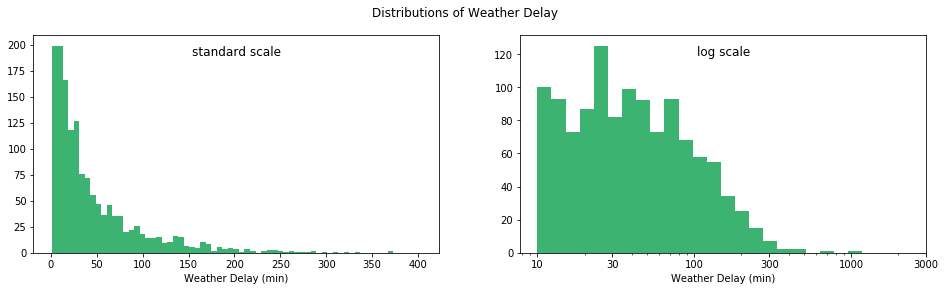

In [24]:
numPlots = 2
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = [8*numPlots, 4], squeeze=False)
fig.suptitle('Distributions of Weather Delay')
var = 'WeatherDelay'
xaxis_label = 'Weather Delay (min)'

min_value = 1
max_value = 400
#max_value = flights_all[var].max()
binsize = 6
bin_edges = np.arange(min_value, max_value+binsize, binsize)
ax[0,0].hist(data = flights, x = var, bins = bin_edges, color='mediumseagreen');
title_string = 'standard scale'
#ax[0,0].set_xlim((left, right))
ax[0,0].set_title(title_string, pad=-20, loc='center')
ax[0,0].set(xlabel=xaxis_label)
#plt.xlabel(xaxis_label)

# log scale plot
max_value = flights_all[var].max()
log_binsize = 0.09
ticks = [10, 30, 100, 300, 1000, 3000]
labels = ['{}'.format(v) for v in ticks]
bin_edges = 10 ** np.arange(1, np.log10(max_value)+log_binsize, log_binsize)
ax[0,1].hist(data = flights, x = var, bins = bin_edges, color='mediumseagreen');
ax[0,1].set_xscale('log')
ax[0,1].xaxis.set_ticks(ticks)
ax[0,1].xaxis.set_ticklabels(labels)
title_string = 'log scale'
ax[0,1].set_title(title_string, pad=-20, loc='center')
ax[0,1].set(xlabel=xaxis_label)
#plt.xlabel(xaxis_label)
plt.show()

## Variables of Interest: Destination and Airline

To proceed with the investigation, I first analyzed the top 10 most frequented destinations and airlines against Arrival Delay, then selected three of each for further study.

In [26]:
# grab lists of the top 10 airports and airlines
top10_dest = flights.groupby('Dest').Dest.count().sort_values(ascending=False)[0:10].index.tolist()
top10_carrier = flights.groupby('UniqueCarrier').UniqueCarrier.count().sort_values(ascending=False)[0:10].index.tolist()

flights_reduced_dest = flights[flights.Dest.isin(top10_dest)]
flights_reduced_carrier = flights[flights.UniqueCarrier.isin(top10_carrier)]

# print('Top 10 Destinations:', top10_dest)
# print('---------------------------------------------------------')
# print('Top 10 Airlines:    ', top10_carrier)

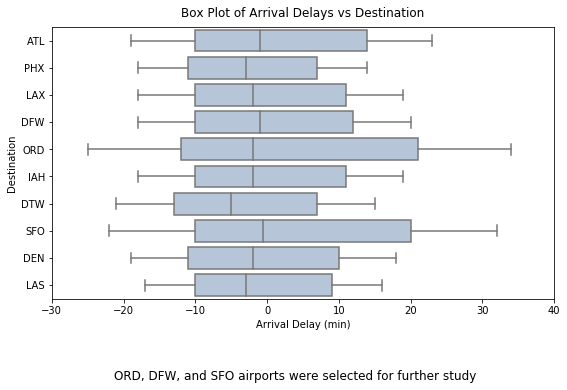

In [28]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = [9,5], squeeze=False)
sb.boxplot(data=flights_reduced_dest, y='Dest', x='ArrDelay', ax=ax[0,0], color='lightsteelblue', whis=0.4, sym='')
ax[0,0].set(xlim=(-30,40))
title_string = 'Box Plot of Arrival Delays vs Destination'
ax[0,0].set_title(title_string, pad=10, loc='center')
ax[0,0].set(xlabel='Arrival Delay (min)')
ax[0,0].set(ylabel='Destination')
caption_string = 'ORD, DFW, and SFO airports were selected for further study'
plt.figtext(0.5, -0.1, caption_string, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

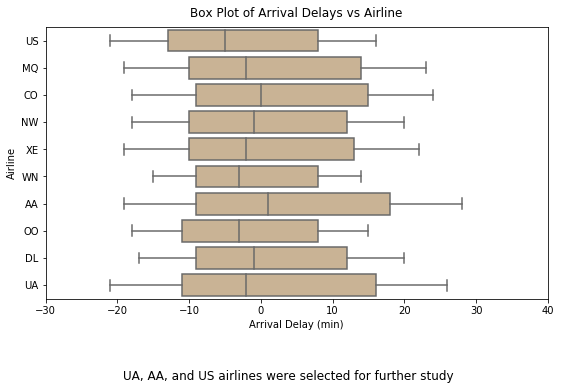

In [30]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = [9,5], squeeze=False)
sb.boxplot(data=flights_reduced_carrier, y='UniqueCarrier', x='ArrDelay', ax=ax[0,0], color='tan', whis=0.4, sym='')
ax[0,0].set(xlim=(-30,40))
title_string = 'Box Plot of Arrival Delays vs Airline'
ax[0,0].set_title(title_string, pad=10, loc='center')
ax[0,0].set(xlabel='Arrival Delay (min)')
ax[0,0].set(ylabel='Airline')
caption_string = 'UA, AA, and US airlines were selected for further study'
plt.figtext(0.5, -0.1, caption_string, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

## Interaction Between Variables of Interest: Weather Delay and Day of Year

While exploring the data, it started to seem that weather delay may be an important swing factor affecting arrival delays. Given this, I thought I would check when weather delays are most prominent. It turns out that weather delays tend to occur most often during Feburary, early summer, and during the peak holiday travel season.

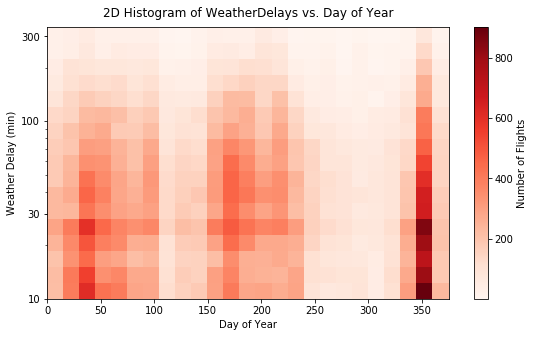

In [31]:
x = flights_all['DayOfYear']
y = flights_all['WeatherDelay']

x_min_val = 0
x_max_val = 366
x_binSize = 15
x_bin_edges = np.arange(x_min_val, x_max_val+x_binSize, x_binSize)

y_min_val = 1
y_max_val = 300
y_logBinSize = 0.09
y_bin_edges = 10 ** np.arange(y_min_val, np.log10(y_max_val)+y_logBinSize, y_logBinSize)

counts, _, _ = np.histogram2d(x, y, bins=(x_bin_edges, y_bin_edges))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9,5])
plt.pcolormesh(x_bin_edges, y_bin_edges, counts.T, cmap = 'Reds')
tick_locs = [10, 30, 100, 300]
labels = ['{}'.format(v) for v in tick_locs]
plt.ylabel('Weather Delay (min)')
plt.xlabel('Day of Year')
title_string = '2D Histogram of WeatherDelays vs. Day of Year'
ax.set_title(title_string, pad=10, loc='center')

ax.figure.axes[-1].set_yscale('log')
plt.yticks(tick_locs, labels)
plt.colorbar()
ax.figure.axes[-1].set_ylabel('Number of Flights')
plt.show()

#### Setting up the Calendar Plots
<br>
Start by writing a function that reduces a dataframe to its median delay values:

In [32]:
# group a df by the column 'varGroupBy', collect medians, only keep 'varsKeep' columns, then reshape the df
'''
    - assumes that elements of varskeep are as follows:
        - 0th element: variable to groupby   /  pivoting: values
        - 1st element: 'Week' variable       /  pivoting: index
        - 2nd element: 'DayOfWeek' variable  /  pivoting: columns
'''
def reduce_df_median(data, varGroupBy, varsKeep):
    # reduce the dataframe
    data_new = data.groupby(varGroupBy).median()
    data_new = data_new[varsKeep]
    
    # convert data type to int
    data_new['Week'] = data_new['Week'].astype(np.int64)
    data_new['DayOfWeek'] = data_new['DayOfWeek'].astype(np.int64)
    
    # reshape the dataframe
    data_new = pd.pivot_table(data_new, values = varsKeep[0], index=[varsKeep[1]], columns = varsKeep[2])
    
    return data_new

In [33]:
flights_days_Arr = reduce_df_median(flights_all, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])
#flights_days_Arr = reduce_df_median(flights_all, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])

# will be used to keep vmin and vmax values consistent across calendar plots
minArrDelay_median = flights_days_Arr.min().sort_values(ascending=True).iloc[0]
maxArrDelay_median = flights_days_Arr.max().sort_values(ascending=False).iloc[0]

## Arrival Delay vs Day of Year, All Destinations and All Airlines

As one might expect, all of these variables are inter-related. One method of depicting the variations is to look at how they vary over the course of a year in a "Calendar Plot" of arrival delays.

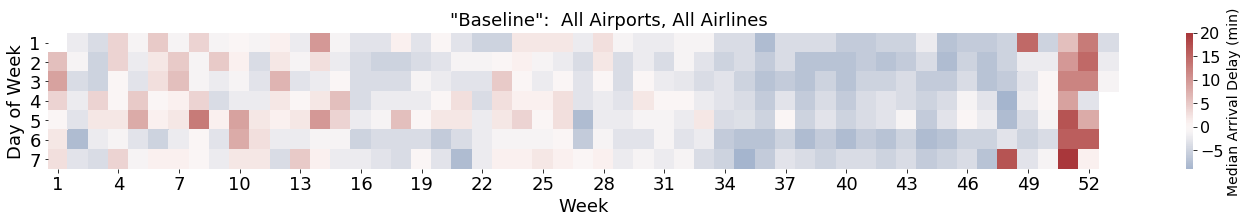

In [34]:
plt.figure(figsize = [24, 2.5])
ax = sb.heatmap(flights_days_Arr, cmap = 'vlag', center = 0, cbar=True, xticklabels=3, 
                vmin = minArrDelay_median, vmax = maxArrDelay_median)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Day of Week', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(rotation=0, ha='right', fontsize=18)
ax.figure.axes[-1].tick_params(labelsize=16)
ax.figure.axes[-1].set_ylabel('Median Arrival Delay (min)', size=14)
title_string=('"Baseline":  All Airports, All Airlines')
plt.suptitle(title_string, x=0.45, y=1.0, fontsize=18)
plt.show()

**There are a couple of things that one can immediately observe from just this one plot:**
* The median arrival delay significantly increases during the holidays
* There are a number of short-lived increases in arrival delays during the winter. These are likely weather-related events.
* There is a prolonged period of early arrivals in the fall. This is clearly a good time to fly.

## Arrival Delay vs Day of Year vs \[Destination, Airline\]

With the "baseline" calendar plot established, it can now be filtered to see how arrival delays change for various destinations and airlines over the course of a year.

**Function to create a calendar plot with a specific vmin and vmax:**

In [35]:
def plotCal_specific_cBar(df, mask, cBarMin, cBarMax, boolXaxis, boolTitle, titleStr):
    df_new = df[mask]
    df_reduced = reduce_df_median(df_new, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])

    # "calendar matrix" of flights with the given mask
    plt.figure(figsize = [24, 2.5])
    ax = sb.heatmap(df_reduced, cmap = 'vlag', center = 0, cbar=True, xticklabels=3, vmin=cBarMin, vmax=cBarMax)
    plt.xlabel('Week', fontsize=18)
    plt.ylabel('Day of Week', fontsize=18)
    plt.xticks(rotation=0, fontsize=18)
    plt.yticks(rotation=0, ha='right', fontsize=18)
    ax.figure.axes[-1].tick_params(labelsize=14)
    ax.figure.axes[-1].set_ylabel('Arrival Delay (min)', size=18)
    
    #add title if requested
    if boolTitle == 'yes':
        plt.suptitle(titleStr, x=0.45, y=1.04, fontsize=18)
    
    #if requested, remove the xAxis labels
    #if boolXaxis == 'no':
        #remove x axis labels
    
    #display plot
    plt.show()

**Function to Plot Arrival delays for multiple airports:**

In [36]:
def plotCal_Airports(df):
    
    # retrieve the median arrival delays for flights with <airport> as a destination
    mask = flights_all['Dest'] == 'ORD'             # select flights with a given mask
    df_new = df[mask]
    df_reduced_ORD = reduce_df_median(df_new, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])
    
    # retrieve the median departure delays for flights with <airport> as a destination
    mask = flights_all['Dest'] == 'DFW'             # select flights with a given mask
    df_new = df[mask]
    df_reduced_DFW = reduce_df_median(df_new, 'DayOfYear', ['DepDelay', 'DayOfWeek', 'Week'])
    
    # retrieve the median departure delays for flights with <airport> as a destinationn origin
    mask = flights_all['Dest'] == 'SFO'             # select flights with a given mask
    df_new = df[mask]
    df_reduced_SFO = reduce_df_median(df_new, 'DayOfYear', ['DepDelay', 'DayOfWeek', 'Week'])
    
    # determine cBarMin and cBarMax
    minORD = df_reduced_ORD.min().sort_values(ascending=True).iloc[0]
    maxORD = df_reduced_ORD.max().sort_values(ascending=False).iloc[0]
    minDFW = df_reduced_DFW.min().sort_values(ascending=True).iloc[0]
    maxDFW = df_reduced_DFW.max().sort_values(ascending=False).iloc[0]
    minSFO = df_reduced_SFO.min().sort_values(ascending=True).iloc[0]
    maxSFO = df_reduced_SFO.max().sort_values(ascending=False).iloc[0]
    cBarMin = min(minORD, minDFW, minSFO)
    cBarMax = max(maxORD, maxDFW, maxSFO)
    boolXaxis = 'yes'
    boolTitle = 'yes'
    
    #plotCal_specific_cBar(df, df['Dest']== 'ORD', cBarMin, cBarMax, boolXaxis, boolTitle, 'O\'Hare Airport (ORD)')
    #plotCal_specific_cBar(df, df['Dest']== 'DFW', cBarMin, cBarMax, boolXaxis, boolTitle, 'Dallas/Fort Worth (DFW)')
    #plotCal_specific_cBar(df, df['Dest']== 'SFO', cBarMin, cBarMax, boolXaxis, boolTitle, 'San Francisco (SFO)')
    
    plotCal_specific_cBar(df, df['Dest']== 'ORD', minORD, maxORD, boolXaxis, boolTitle, 'O\'Hare Airport (ORD)')
    plotCal_specific_cBar(df, df['Dest']== 'DFW', minDFW, maxDFW, boolXaxis, boolTitle, 'Dallas/Fort Worth (DFW)')
    plotCal_specific_cBar(df, df['Dest']== 'SFO', minSFO, maxSFO, boolXaxis, boolTitle, 'San Francisco (SFO)')

**Function to Plot Arrival delays for multiple airlines:**

In [37]:
def plotCal_Airlines(df):
    
    # retrieve the median arrival delays for flights with <airport> as a destination
    mask = flights_all['UniqueCarrier'] == 'UA'             # select flights with a given mask
    df_new = df[mask]
    df_reduced_UA = reduce_df_median(df_new, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])
    
    # retrieve the median departure delays for flights with <airport> as a destination
    mask = flights_all['UniqueCarrier'] == 'AA'             # select flights with a given mask
    df_new = df[mask]
    df_reduced_AA = reduce_df_median(df_new, 'DayOfYear', ['DepDelay', 'DayOfWeek', 'Week'])
    
    # retrieve the median departure delays for flights with <airport> as a destinationn origin
    mask = flights_all['UniqueCarrier'] == 'US'             # select flights with a given mask
    df_new = df[mask]
    df_reduced_US = reduce_df_median(df_new, 'DayOfYear', ['DepDelay', 'DayOfWeek', 'Week'])
    
    # determine cBarMin and cBarMax
    minUA = df_reduced_UA.min().sort_values(ascending=True).iloc[0]
    maxUA = df_reduced_UA.max().sort_values(ascending=False).iloc[0]
    minAA = df_reduced_AA.min().sort_values(ascending=True).iloc[0]
    maxAA = df_reduced_AA.max().sort_values(ascending=False).iloc[0]
    minUS = df_reduced_US.min().sort_values(ascending=True).iloc[0]
    maxUS = df_reduced_US.max().sort_values(ascending=False).iloc[0]
    cBarMin = min(minUA, minAA, minUS)
    cBarMax = max(maxUA, maxAA, maxUS)
    boolXaxis = 'yes'
    boolTitle = 'yes'
    
    #plotCal_specific_cBar(df, df['UniqueCarrier']== 'UA', cBarMin, cBarMax, boolXaxis, boolTitle, 'United Airlines (UA)')
    #plotCal_specific_cBar(df, df['UniqueCarrier']== 'AA', cBarMin, cBarMax, boolXaxis, boolTitle, 'American Airlines (AA)')
    #plotCal_specific_cBar(df, df['UniqueCarrier']== 'US', cBarMin, cBarMax, boolXaxis, boolTitle, 'US Airways (US)')
    
    plotCal_specific_cBar(df, df['UniqueCarrier']== 'UA', minUA, maxUA, boolXaxis, boolTitle, 'United Airlines (UA)')
    plotCal_specific_cBar(df, df['UniqueCarrier']== 'AA', minAA, maxAA, boolXaxis, boolTitle, 'American Airlines (AA)')
    plotCal_specific_cBar(df, df['UniqueCarrier']== 'US', minUS, maxUS, boolXaxis, boolTitle, 'US Airways (US)')

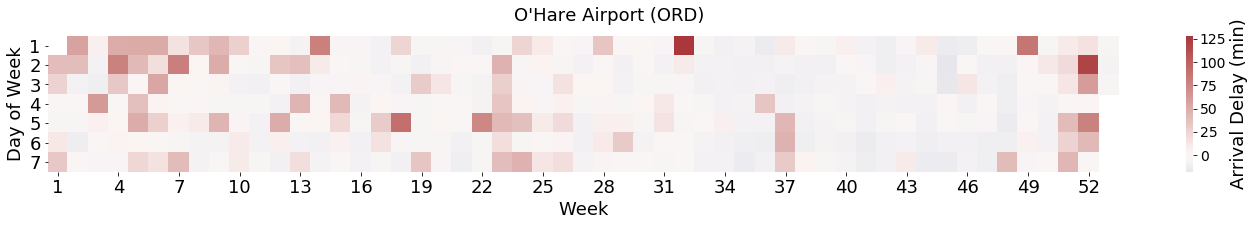

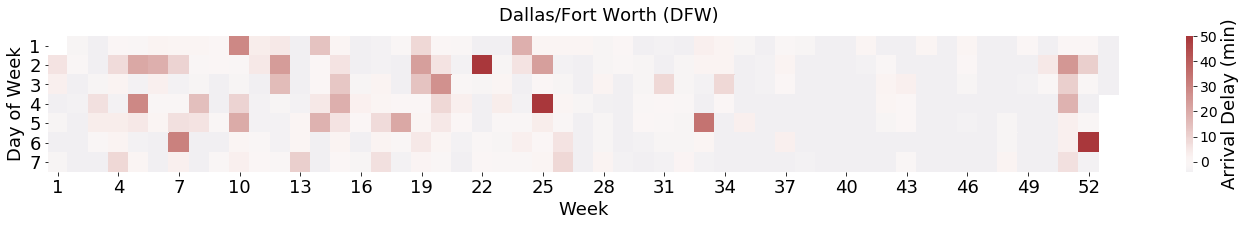

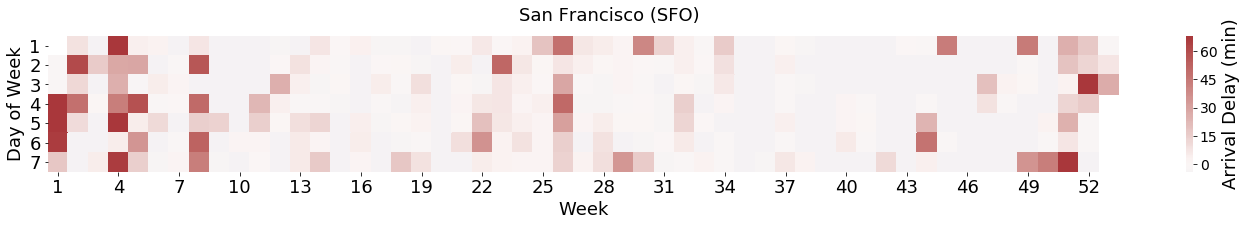

In [38]:
plotCal_Airports(flights_all)    # plot the calendar matrix

**After filtering by airport, one can see that different airports have different cycles of arrival delay:**
* Some airports, such as ORD, have a fairly consistent and long Arrival Delay throughout the year
  * as denoted by their higher max value for Arrival Delay and/or the relative lack of color variation through large portions of the year
* Other airports, such as SFO, tend to be much more cyclical
  * as denoted by the periods of relatively shorter delays in the spring and/or fall
<br>

**Some things remain common across airports, however:**
* Delays for each airline increased during the holidays
* The probability of long arrival delays increases during the winter months
  * The amount of increase seems dependent on the airport, which makes sense. Some airports would be more susceptible to winter weather.

**Finally, let's look at a calendar plot filtered by Airline...**

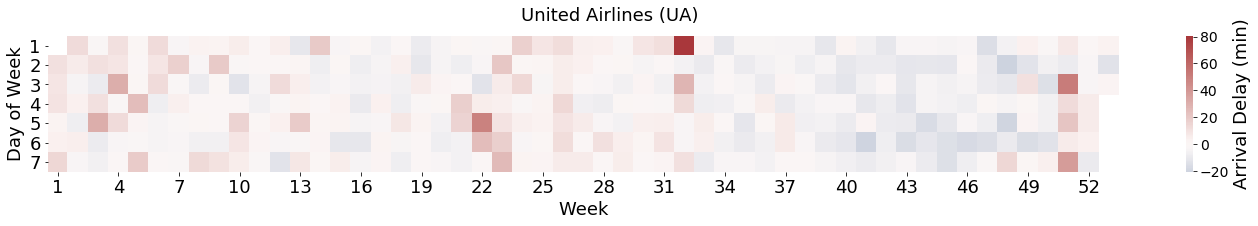

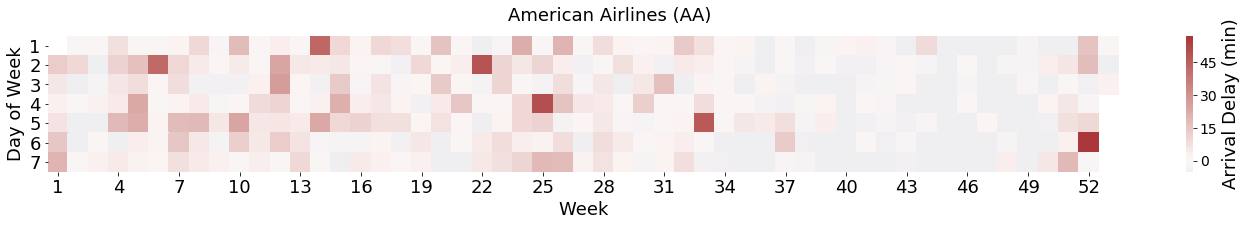

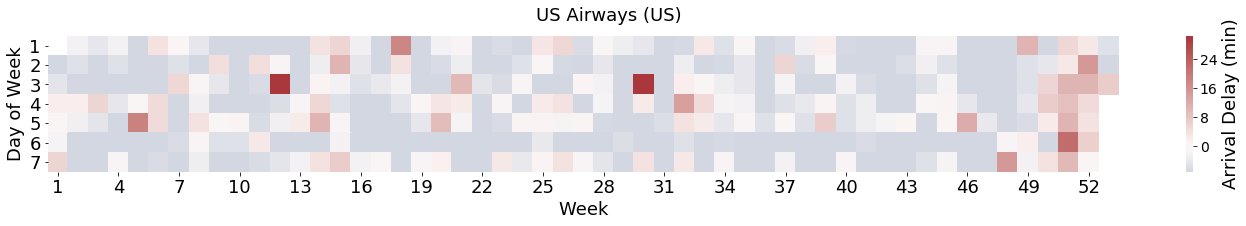

In [39]:
plotCal_Airlines(flights)    # plot the calendar matrix

* After filtering by airline, one can see that arrival delay can increase (or decrease) greatly depending on the airline one chooses

* As with airports, some airlines (such as American Airlines) seem to have consistently long delays

## Summary

* In summary, it seems that time of year, weather, airport, and airline are some of the most significant factors affecting the length of a given flight's arrival delay
<br>

* Some airports (such as ORD) have consistently long delays, whereas others (such as SFO) are much more prone to large swings in the amount of delay
  * The same can be said for airlines
  * It pays to research your airport and airline of choice ahead of time - especially if you live in an area with multiple airports!
<br><br>

* If you wanted to have little to no arrival delay in 2008, some good ways to attempt this would have been:
  * Fly in the fall (for most airports and/or airlines)
  * Fly on US Airways (at practically any time of the year) - they had some great on-time performance in 2008!